In [185]:
# testing the Build tree function

In [317]:
import numpy as np
import copy
import matplotlib.pyplot as plt

from dataclasses import dataclass

def sample_momentum_vector(D=2, eta=0.05):
    means = np.zeros(D)
    cov = np.eye(D)
    return eta*(np.random.multivariate_normal(means, cov, 1).flatten())

def rotate_vector_2d(vector, phi_d):
    phi = phi_d*np.pi/180
    vec = vector.reshape(len(vector),1)
    R = np.array([[np.cos(phi), -np.sin(phi)],
                  [np.sin(phi), np.cos(phi)]])
    return (R@vec).flatten()

def leapfrog(theta, r, eps):
    phi_d = np.random.rand()*(40-(-40))-40
    r = rotate_vector_2d(r, phi_d/2)
    theta = theta + eps*r
    r = rotate_vector_2d(r, phi_d/2)
    return (theta, r)
    

iter_color_dict = {0:"black",1:"green",2:"blue",3:"orange",
                   4:"magenta",5:"darkblue", 6:"yellow", 
                   7:"lightgreen", 8:"black", 9:"blue"}

@dataclass
class nutsSample:
    time:              int = None
    iteration:         int = None
    theta:             list = None
    r:                 list = None
    valid:             bool = True
        
    def copy(self):
        return copy.deepcopy(self)
    
    def plot(self):
        self.plot_sample()
        self.plot_momentum()
        
    def plot_sample(self):
        c = iter_color_dict[(self.iteration)%10]
        plt.scatter(self.theta[0],self.theta[1],color=c)
        
    def plot_momentum(self):
        fac = 1/10
        x2, y2 = self.theta[0]+fac*self.r[0], self.theta[1]+fac*self.r[1]
        plt.plot([self.theta[0],x2],[self.theta[1],y2], 'r-')
        
    def leapfrog(self, eps):
        self.theta, self.r = leapfrog(self.theta, self.r, eps)
        
def build_naive_tree(sample, height, direction, eps, iteration):
    if height == 0:
        s = sample.copy()
        s.iteration = iteration
        s.time = sample.time+direction
        s.leapfrog(direction*eps)
        crit1 = np.random.rand() > 0.05
        C1 = []
        C1.append(s)
        return(s, s, C1, crit1)
    else:
        s_minus, s_plus, C1, crit1 = build_naive_tree(sample, height-1, direction, eps, iteration)
        if direction == -1:
            s_minus, tmp, C2, crit2 = build_naive_tree(s_minus, height-1, direction, eps, iteration)
        else:
            tmp, s_plus, C2, crit2 = build_naive_tree(s_plus, height-1, direction, eps, iteration)
        crit1 = crit1*crit2
        C1 = C1 + C2
        return (s_minus, s_plus, C1, crit1)
    
def naive_NUTS(eps, max_depth=8):
    s0 = nutsSample(time=0, iteration=0, theta=[0,0])
    s0.r = sample_momentum_vector()
    s_plus = s_minus = s0
    C = [s0]
    j = 0
    crit = 1
    while crit == 1:
        d = 1 - 2*np.random.randint(2)
        if d == -1:
            s_minus, tmp, C1, crit1 = build_naive_tree(s_minus, j, d, eps, j+1)
        else: 
            tmp, s_plus, C1, crit1 = build_naive_tree(s_plus, j, d, eps, j+1)
        if crit1 == 1: C = C + C1
        crit = crit1
        j = j + 1
        if j==max_depth: break
    return (C)

In [319]:
def check_uturn(sample_right, sample_left):
    theta_diff = sample_right.theta - sample_left.theta
    

IndexError: list index out of range

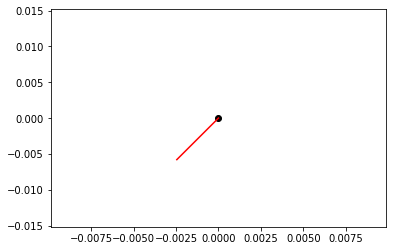

In [343]:
C = naive_NUTS(0.2)
for sample in C:
    sample.plot_sample()
    sample.plot_momentum()

s1 = C[0]
s2 = C[1]

theta_diff = s1.theta - s2.theta
np.dot(theta_diff, -s1.r)

In [188]:
nodes = [0]
def build_tree(node, height, direction):
    #print("------------------------------------------")
    #print("in node: ", node)
    if height==0:
        node_x = node + direction
        nodes.append(node_x)
        #print("new node: ", node_x)
        #print("S2: applying probability stopping criterion!")
        return(node_x, node_x)
    else:
        node_n, node_p = build_tree(node, height-1, direction)
        if direction==-1:
            node_n, bla = build_tree(node_n, height-1, direction)
        else:
            bla, node_p = build_tree(node_p, height-1, direction)
        print("S1: check for dot product between: ", node_p, "(p) and ", node_n, "(n)")
        return(node_n, node_p)
    
def naive_nuts_iteration():
    node_p = 0
    node_n = 0
    j = 0
    while(1):
        print("+++++++++++++++++++++++++++++++++++++")
        v = 1
        if np.random.randint(2)<1: v = -1
        if v==-1:
 #           print("build left tree!")
            node_n, bla = build_tree(node_n, j, v)
        else:
#            print("build right tree!")
            bla, node_p = build_tree(node_p, j, v)
        print("S1: check for dot product between: ", node_p, "(p) and ", node_n, "(n)")
        #if np.random.randint(7)<1: break
        if j == 3 : break
        j = j + 1
    

In [179]:
nodes

[0, -1, -2, -3, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [189]:
naive_nuts_iteration()

+++++++++++++++++++++++++++++++++++++
S1: check for dot product between:  1 (p) and  0 (n)
+++++++++++++++++++++++++++++++++++++
S1: check for dot product between:  3 (p) and  2 (n)
S1: check for dot product between:  3 (p) and  0 (n)
+++++++++++++++++++++++++++++++++++++
S1: check for dot product between:  5 (p) and  4 (n)
S1: check for dot product between:  7 (p) and  6 (n)
S1: check for dot product between:  7 (p) and  4 (n)
S1: check for dot product between:  7 (p) and  0 (n)
+++++++++++++++++++++++++++++++++++++
S1: check for dot product between:  -1 (p) and  -2 (n)
S1: check for dot product between:  -3 (p) and  -4 (n)
S1: check for dot product between:  -1 (p) and  -4 (n)
S1: check for dot product between:  -5 (p) and  -6 (n)
S1: check for dot product between:  -7 (p) and  -8 (n)
S1: check for dot product between:  -5 (p) and  -8 (n)
S1: check for dot product between:  -1 (p) and  -8 (n)
S1: check for dot product between:  7 (p) and  -8 (n)
